# Biomass growth in a genome-scale metabolic network

## Contents

* molecular component analysis
* minimal environments

 In this analysis we try to identify the molecular components of a cell (protein, DNA, RNA, lipids) whose precursors need the greatest amounts of resources for their synthesis. Different networks were prepared with different growth objectives, either missing a major component or only focusing on one.


In [2]:
## Load libraries and import all Models

In [3]:
import cobra
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import logging
# Disable all log messages at the root logger level (including warnings)
logging.disable(logging.CRITICAL)


In [4]:
# import all models
models = {}
for fname in glob.glob("data/*.xml"):
    key = fname.replace("iAF1260", "").replace(".xml", "").replace("_", "")
    if key == "":
        key = "WT+"

    models[key] = cobra.io.read_sbml_model(fname)

## Relationship of Growth and missing compartments
The metabolites in the biomass (objective) function for E. coli are the metabolites that are required for the growth of the cell. They comprise amino acids (in proteins), deoxynucleotide-triphosphates (DNA), nucleotide-triphosphates (RNA), lipids, and various cofactors. Their relative proportions are known from experiments. The four metabolic models that are part of this analysis contain different biomass objective functions that have been edited such that each is missing one major constituent (no_*.xml) or contain . We use FBA to compute the growth flux for each biomass function in a glucose-minimal environment.
A minimal environment or minimal medium is a medium which contains only one source of each essential element (commonly carbon, nitrogen, oxygen, phosphorus and sulfur). In a glucose-minimal medium, glucose is the only source of carbon.
Compare your values with the wild type biomass function. Why do you think there is a change in the growth flux? In which of the four classes do you observe the greatest change in the growth flux values between the alternative and the wild type biomass functions? Why? (Hint: Think of the resources required for a major constituent's synthesis.)

Text(0, 0.5, 'Growth flux')

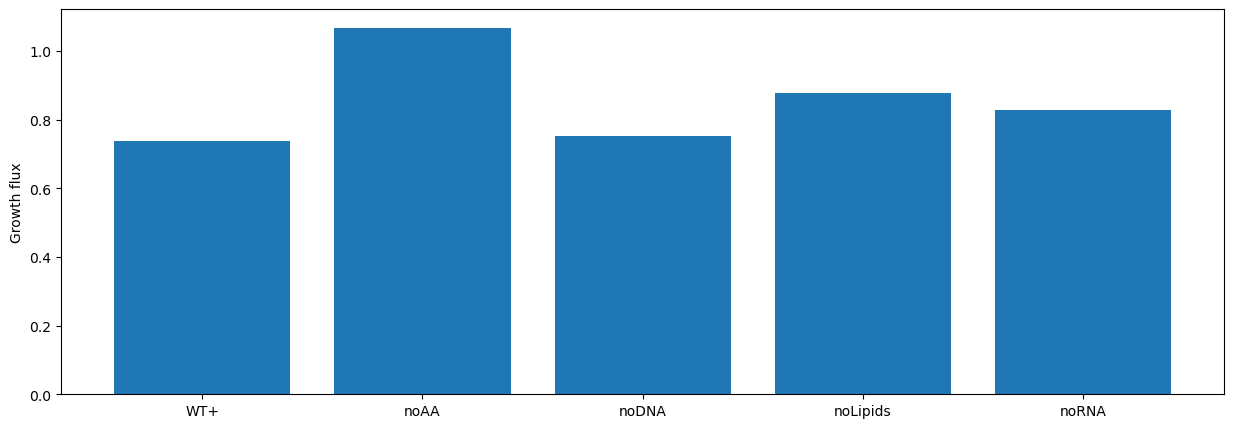

In [5]:
# we extract the model missing a component
no_models = {key:models[key] for key in models if ("no" in key) or (key == "WT+")}


#compute FBA for minimal glucose model of all models
FBAs = []
for key in no_models.keys():
    for react in models[key].exchanges:
        if react.id != "EX_glc_DASH_D_b": # not glucose
            for met in react.metabolites:
                if "C" in met.elements.keys():
                    react.lower_bound = 0 # set production to zero to get minimal glucose system
    # print("##########################")
    # print(f"FBA of {key}")
    fba_solution = models[key].optimize()
    # print(fba_solution.objective_value)
    FBAs.append(fba_solution.objective_value)

plt.figure(figsize = (15, 5))
plt.bar(no_models.keys(), FBAs)
plt.ylabel("Growth flux")

The model where AA production is neglected has the highest peak, because AA production is very costly. This way the system can concentrate more on growth. Obviously this is complete nonsense from a biological perspective as AA are needed for growth.

## Essential Reactions in Network only producing one compartment

Now we identify essential reactions and the pathways they belong to for the synthesis of the four major biomass constituents (amino acids, lipids, DNA, RNA) of a cell.
Amino acids (in proteins), deoxynucleotide-triphosphates (in DNA), nucleotide-triphosphates (in RNA), lipids, and various cofactors are the metabolite precursors that are required for the growth of a cell. The four metabolic models that are part of this section all contain different biomass objective functions, each of which contains only one major constituent at a time (as opposed to the previous analysis, where the functions contained all but one constituent).

In [6]:
if __name__ == "__main__":

    from cobra.flux_analysis import single_reaction_deletion


    # only_models = {key:models[key] for key in models if not ("no" in key) or (key == "WT+")}
    # load the reactions and their respective subsystems:
    subsystems = pd.read_csv("data/iAF1260_subsystems.csv", sep = ";")
    # keys we want to include
    only_keys = ["AA", "Lipids", "RNA", "DNA"]
    # a pd dataframe to store the results in wide format
    essential_counts = pd.DataFrame(data = 0, columns = subsystems["subsystem"].unique(), index = only_keys)

    # compute FBA for minimal glucose model of all models
    # essential_reactions = {"AA":{}, "Lipids":{}, "RNA":{}, "DNA":{}}
    for key in only_keys:
        deletion_results = single_reaction_deletion(models[key])
        # mask all the reactions which are essential (approx 0)
        mask = deletion_results["growth"].round(3) == 0
        # find the subsystem in the df
        react_ids = deletion_results[mask]["ids"]
        for id in react_ids:
            # get the id of the reaction to key the frame
            id = list(id)[0]
            # print(id)
            subsys = list(subsystems[subsystems["reaction_id"] == id]["subsystem"])[0]
            # increase the counter
            essential_counts.loc[key, subsys] += 1
            # append them to dict
            # essential_reactions[key][id] = subsys

    # print(essential_reactions)
    # print(subsystems)

### Dirty Visualization

To plot the counts of essential reactions of the respective subsystem we could quick and dirty plot, but there is very little overview in that.


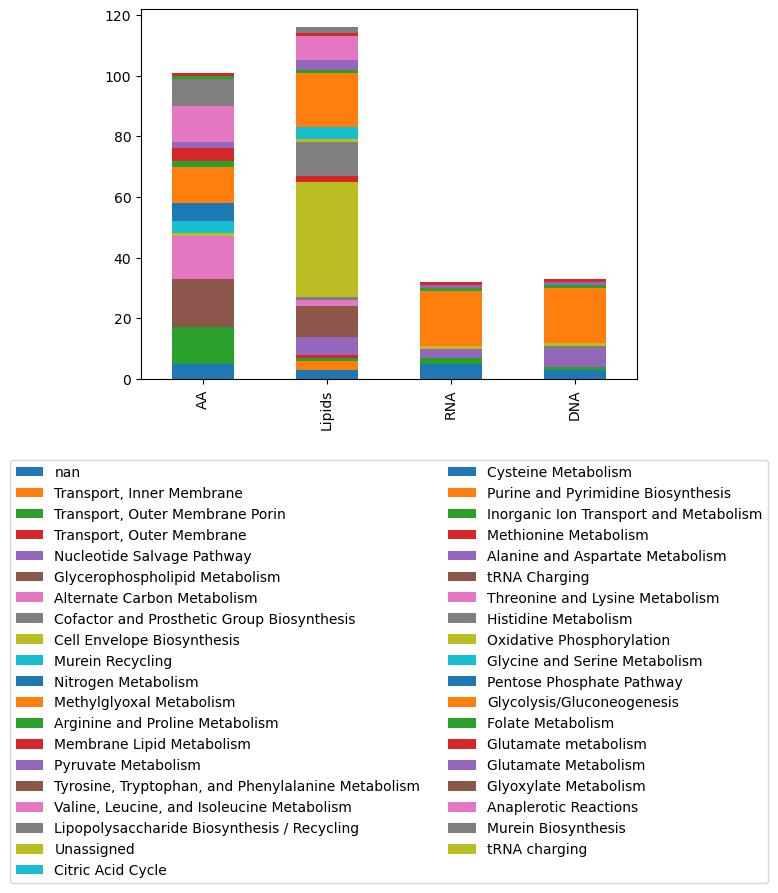

In [7]:
# plot dirty from the wide frame
essential_counts.plot(kind = "bar", stacked = True, legend = False)
plt.legend(loc = "upper center",
           bbox_to_anchor = (0.5,-0.2),
           ncols = 2)

### Matplotlib stacked subplots

We can also cut the data frame in dictionaries per component, and plot the subsystems stacked in seperate subplots. This way we have the dimensions of the legend under control as not all subsystems occur in all components.

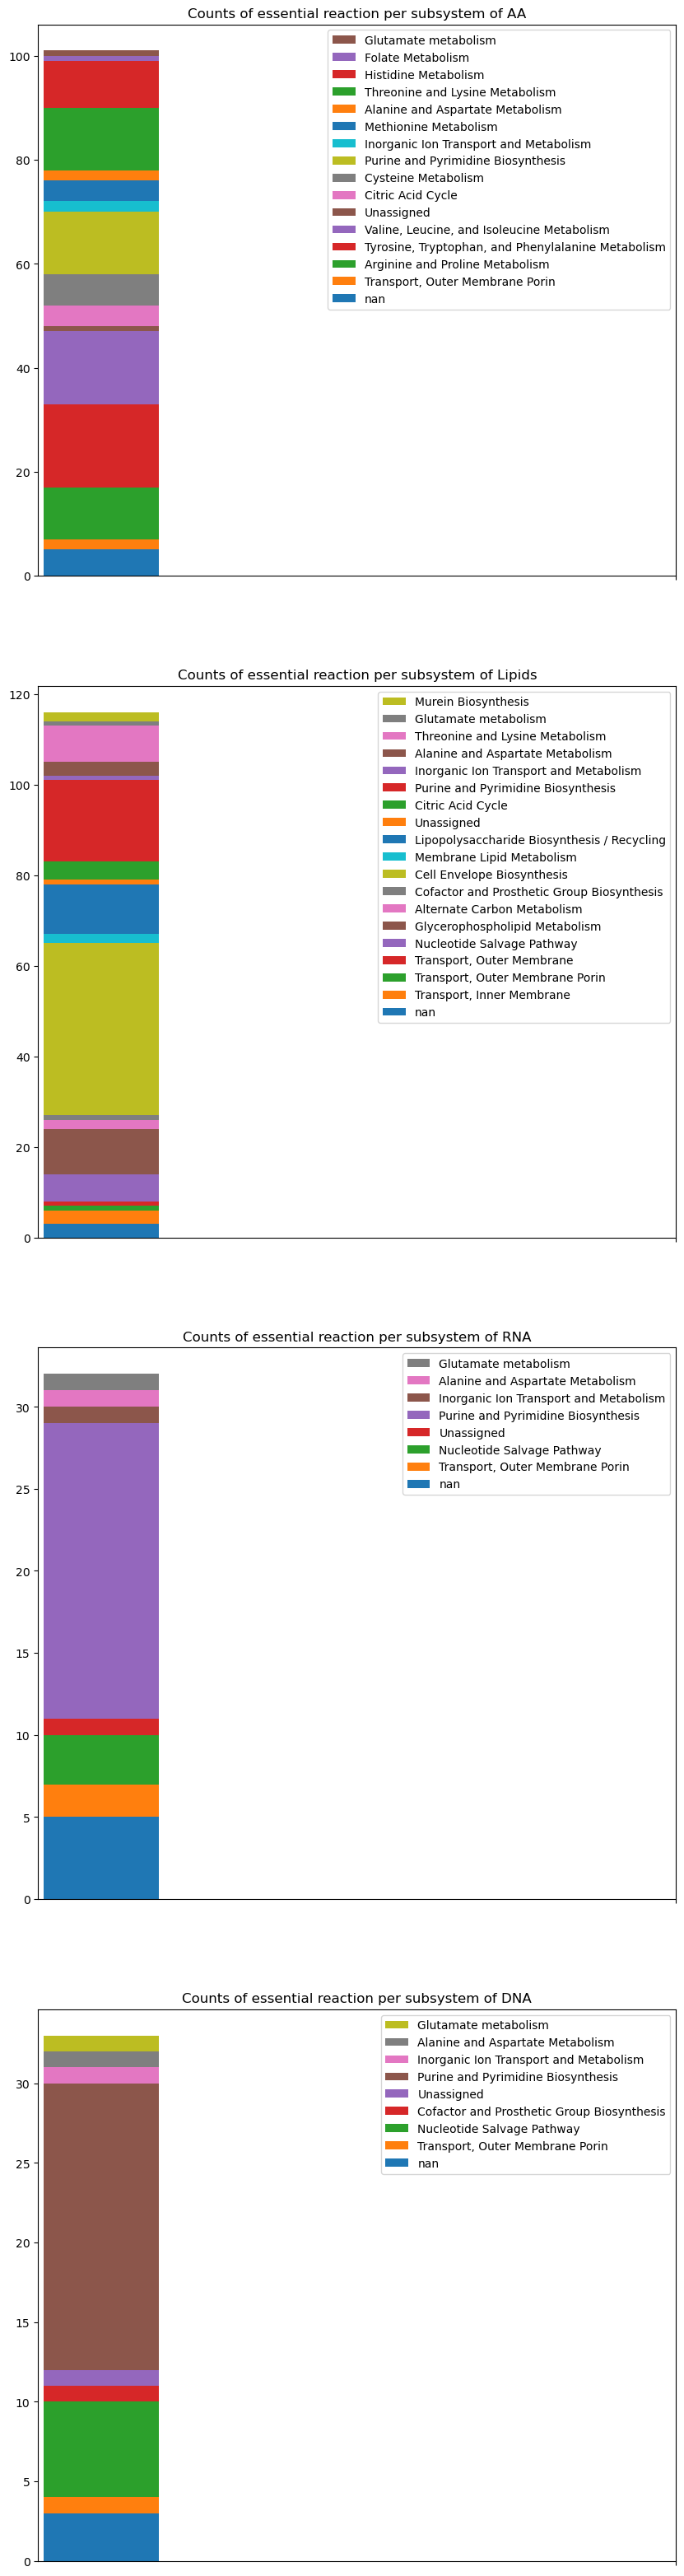

In [8]:
# cut it in 4 data frames for better overview in the plots
counts = {key:essential_counts.loc[key, :] for key in only_keys}

# clear the series where they are zero
for key in counts.keys():
    counts[key] = counts[key].loc[np.logical_and(counts[key] != 0, counts[key] != key)]

fig, axs = plt.subplots(nrows=4, ncols=1, figsize = (10, 40))

for i, key in enumerate(counts.keys()):
    # set the bottom to stack and the width
    bottom = 0
    width = 0.2
    dict(counts[key]).items()
    artists = []
    # stack the seperate subcategories
    for keyx, count in dict(counts[key]).items():
        p = axs[i].bar(x = key, height = count, width = width, label = keyx, bottom = bottom)
        artists.append(p)
        axs[i].set_xticks([""])

        bottom += count

    # reverse the order of the legend for better overview
    axs[i].legend(handles = artists[::-1])
    # set a title
    axs[i].set_title(f"Counts of essential reaction per subsystem of {key}")


### Interactive plots with plotly

Separating the data to keep the legend readable visualizes the subsystems in each compartments better, but we loose the ability to compare subsystems, as the legend have different colors. We could try to control the color coding manually, but instead we try an interactive approach with plotly.

In [22]:
# melt the data into long format
essential_counts["compartment"] = essential_counts.index
essential_counts_long = pd.melt(frame = essential_counts,
                                value_vars= essential_counts.columns,
                                id_vars="compartment",
                                value_name="count",
                                var_name="subsystem")
fig = px.bar(essential_counts_long,
             x = "compartment",
             y = "count",
             color = "subsystem")
fig.update_layout(width = 700,
                  height = 1500,
                  legend = dict(orientation = "h",
                                traceorder = "normal",
                                y = -0.2,
                                x = 0))

This is much better as we can hover over different subbars to see their count, which makes subsystems role comparable along compartments. Here it is also straightforward to see that Lipids contain the most essential reaction, as well as that RNA and DNA require reactions in similar subsystems.